<a href="https://colab.research.google.com/github/wdilantha/HAR-LSTM_ACEl/blob/master/Copy_of_HAR_LSTM_FirstAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data
- [Downloaded file](http://www.cis.fordham.edu/wisdm/dataset.php)
- Unzipped and copied the folder onto my Google Drive.
- Mounted Google Drive.  
- Read the data into numpy arrays.



In [ ]:
#
# Mount Google Drive.
#
from google.colab import drive
drive.mount('/content/drive')

## Data in WISDM Data?



In [ ]:
! head -5 '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [ ]:

!sed 's/;//' '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'  > '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi'

In [ ]:
! head -5 '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi'

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
33,Jogging,49106062271000,5.012288,11.264028,0.95342433
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


## Loading data


In [ ]:
#
# Load Data into a Pandas DataFrame.
#
# TODO: The z-axis comes in as an object = note the semicolon as the end.  Hmmm....
import pandas as pd
columns = ['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi',header=None,names=columns,sep=',')
df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


# Explore
what's in this dataset?
## Rows and Columns
Looking at the results for df.info() and df.shape, we see there are 1,098,204 accelerometer measurements.  Each measurement recorded the x/y/z accelerometer readings (3 of the columns) along with the user who was wearing the acceleromenter, the activity they were doing, and a timestamp to identify where in the timeseries this reading occured.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098204 non-null int64
activity     1098204 non-null object
timestamp    1098204 non-null int64
x-axis       1098204 non-null float64
y-axis       1098204 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [ ]:
df.shape

(1098204, 6)

## Number of Readings by Activity
A large chunk of the measurements are done for users walking.  There are far fewer measurements for folks standing.

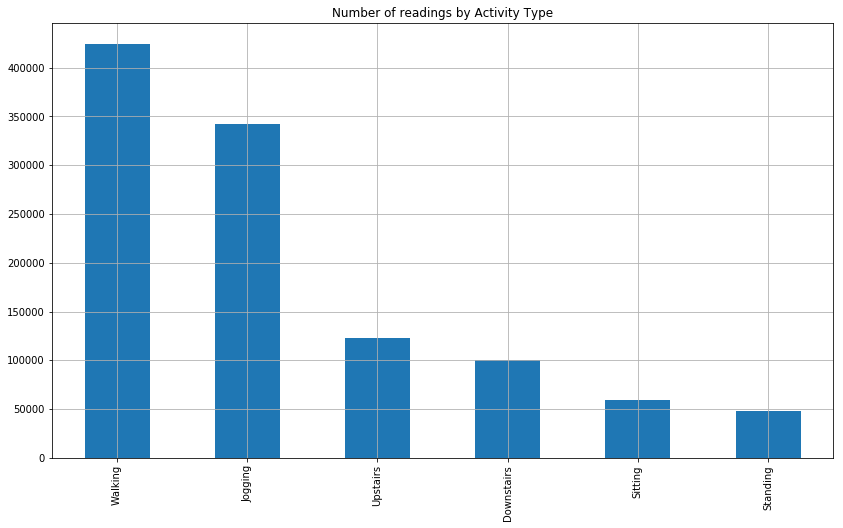

In [ ]:
countOfActivities = df['activity'].value_counts()
countOfActivities.plot(kind='bar',title='Number of readings by Activity Type',figsize=(14,8),grid=True);

## Contribution of Each User
Which user contributed the most readings?  The least?...

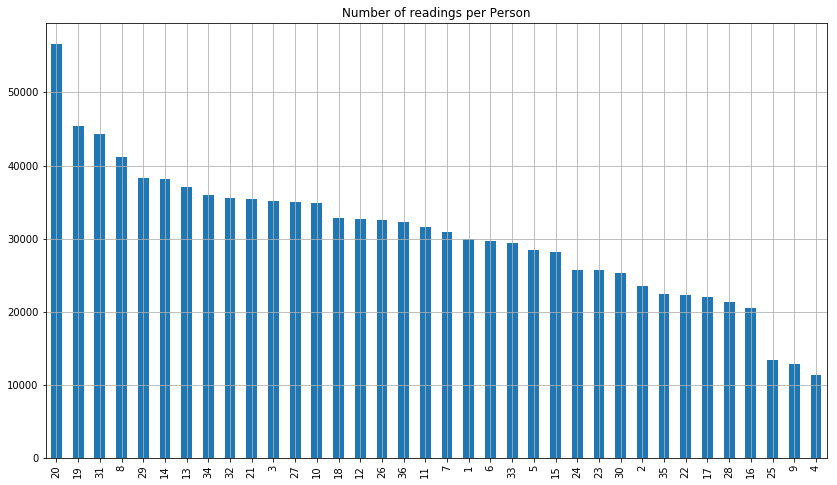

In [ ]:
countOfReadingsPerPerson = df['user'].value_counts()
countOfReadingsPerPerson.plot(kind='bar',title='Number of readings per Person',figsize=(14,8),grid=True);


# Visualize

In [ ]:
def plot_activity(activity,df,start=0,stop=200):
  extractRowsOfActivity = (df['activity'] == activity)  # Output will be true/false.
  data = df[extractRowsOfActivity] # data has only rows that are for the requested activity.
  data = data[['x-axis','y-axis','z-axis']] # data has only the accelerometer columns.
  data = data[start:stop]
  
  ax = data.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.

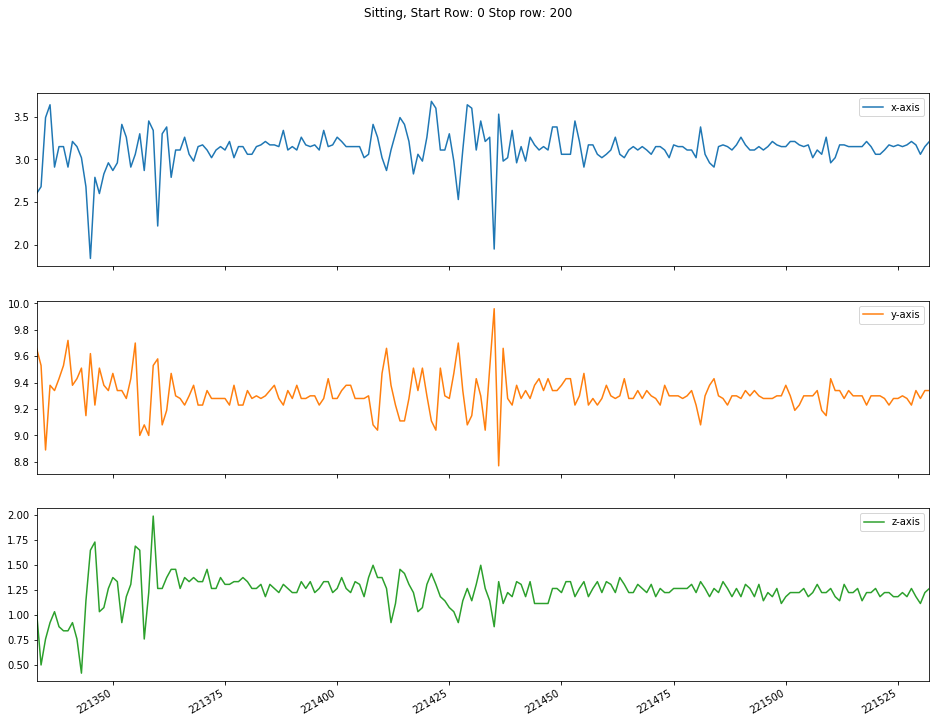

In [ ]:
plot_activity('Sitting',df)

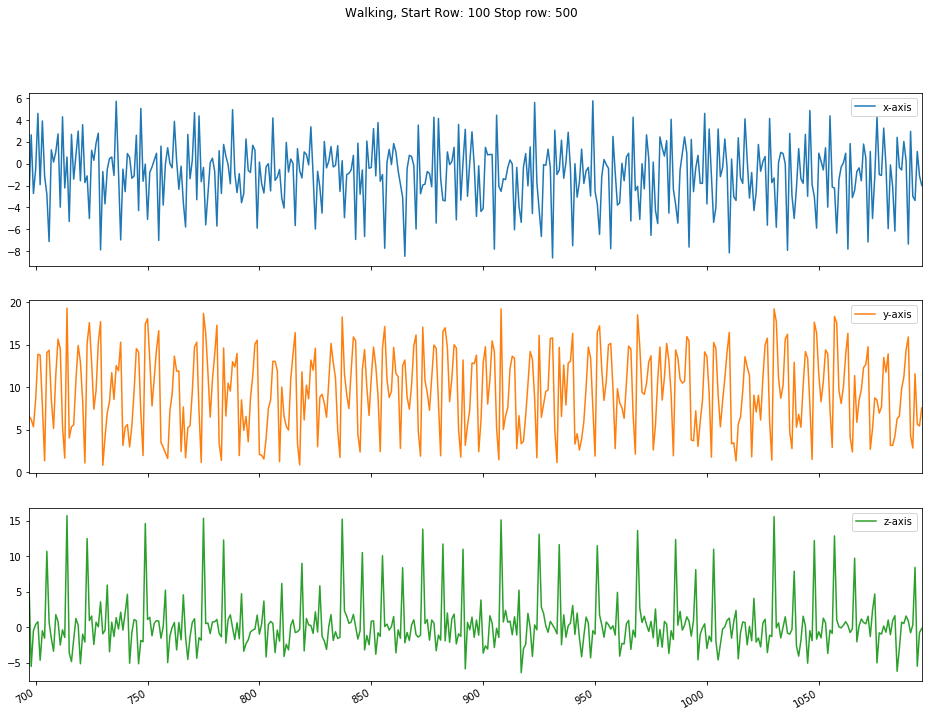

In [ ]:
plot_activity('Walking',df,100,500)

# Data Preprocessing 
The data preprocessing includes:  
- Normalizing the measurements to be between 0 and 1.
- Transforming the measurements to be in a 3-D array of [samples, timesteps,features].
- One hot encoding the activity names.
- Breaking the 3-D array into a training, validation, and test dataset.  

## Nomalizing the Data
Not needed for this dataset.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df['x-axis_mms'] = mms.fit_transform(df[['x-axis']])
df['y-axis_mms'] = mms.fit_transform(df[['y-axis']])
df['z-axis_mms'] = mms.fit_transform(df[['z-axis']])
df.describe().round(2)

,user,timestamp,x-axis,y-axis,z-axis,x-axis_mms,y-axis_mms,z-axis_mms
count,1098204.00,1.098204e+06,1098204.00,1098204.00,1098203.00,1098204.00,1098204.00,1098203.00
mean,18.86,3.340907e+13,0.66,7.26,0.41,0.51,0.68,0.51
std,10.21,4.944967e+13,6.85,6.75,4.75,0.17,0.17,0.12
min,1.00,0.000000e+00,-19.61,-19.61,-19.80,0.00,0.00,0.00
25%,10.00,2.019113e+12,-2.87,3.17,-2.22,0.42,0.57,0.45
50%,19.00,9.722777e+12,0.27,7.93,0.00,0.50,0.69,0.50
75%,28.00,4.996570e+13,4.44,11.56,2.72,0.61,0.79,0.57
max,36.00,2.093974e+14,19.95,20.04,19.61,1.00,1.00,1.00


## 3D Array
Keras/Tensorflow expects data to be chunked into a 3D array of (samples,time steps,features) before feeding into a model.
### Samples
Samples are chunks of rows/columns.  So for example, if we have 1,000 rows of measurements, we chould break these into 10 chunks/samples.  Each sample would contain 100 rows.  

### Rows And Columns
Rows and Columns are what we are typically familiar with when we take sensor readings over time.  For example, we might take a reading every ms for one second.  There are 1,000 ms in a second, so this gives us 1,000 rows.  The number of columns will depend on what we read off the sensors plus any other additional data we want to include.  In this dataset, the columns include:  
- which user is taking the measurement as they walk, etc.  
- what activity the user is doing such as walking, sitting, etc.
- the timestamp when the reading was taken.
- the x/y/z-axis readings from the accelerometer (in three columns). 

When we chunk up the data, we'll only be looking at the x/y/z-axis normalized to one readings.  
  


In [ ]:

import numpy as np
from scipy import stats
nSamplesInEach = 200
nFeatures = 3
samples = []
labels = []
for i in range(0,len(df)-nSamplesInEach,nSamplesInEach):
  xa = df['x-axis_mms'].values[i:i+nSamplesInEach]
  ya = df['y-axis_mms'].values[i:i+nSamplesInEach]
  za = df['z-axis_mms'].values[i:i+nSamplesInEach]
  label = stats.mode(df['activity'][i:i+nSamplesInEach])
  label = label[0][0]

  samples.append([xa,ya,za])
  labels.append(label)
np.array(samples).shape

(5491, 3, 200)

### Reshape
We want (samples, time steps, features).  The data set is in 3-D but (5491 samples,3 rows of features,200 columns of time steps).  We need to reshape this to (samples,time series, features).


In [ ]:
reshaped_s = np.array(samples).reshape(-1,nSamplesInEach,nFeatures)
np.array(reshaped_s).shape


(5491, 200, 3)

## One Hot Encode Labels
Each one of the samples is labeled with a string representing the activity the sample contains.

In [ ]:
labels[:10]

['Jogging',
 'Jogging',
 'Jogging',
 'Walking',
 'Walking',
 'Walking',
 'Upstairs',
 'Upstairs',
 'Upstairs',
 'Downstairs']

In [ ]:

labels = np.array(pd.get_dummies(labels))
labels[:10]

array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
labels.shape

(5491, 6)

Jogging is represented by a 1 in the second column, Walking in the sixth column, Upstairs in the fifth column, and Downstairs in the first column.

## Training, Validation, and Test Data
### Split into Train and Test Data sets

We'll use 80% of the measurements for training and validation.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(reshaped_s,labels,test_size=.2,random_state=42)
len(X_train)

4392

In [ ]:
len(X_test)

1099

### Create a validation set
_source:[Getting Started with TensorFlow...](https://youtu.be/tYYVSEHq-io?t=3672)_

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).  
  
__note:__ I'm not sure how much of the training data to give to validating.  I'll give 20%, which is about 878 samples.  The training samples are then samples 1 through 4392 - 878 = 3514 training samples, 878 validation samples.



In [ ]:
X_train_partial = X_train[:3515]
X_val = X_train[3515:]
Y_train_partial = Y_train[:3515]
Y_val = Y_train[3515:]

## Build the model

Building the model is the "secret sauce."  At this point, I have just a small clue on what I should do here.  For example, I'm using an LSTM layer because that is what I've seen others using when working with timeseries sensor data. I throw in the dense layer because...well...why not?...Ideally, I can find a model that has been researched...


* How many layers to use in the model?
* How many *hidden units* to use for each layer?  
* What neural network to use?

In [ ]:
# Get the input shape -> (samples, time steps, features)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

n_timesteps: 200, n_features: 3, n_outputs: 6


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

### First Try at Model
Here I'm slapping some layers..I have no intuitive feel..I know we have timeseries data so I put an LSTM layer in.  

In [ ]:
model = keras.Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 606       
Total params: 62,406
Trainable params: 62,406
Non-trainable params: 0
_________________________________________________________________


### Second Try at Modeling
I'm looking at the Tensorflow in [this article](https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64).  This model reflect what I think is going on...but I have no fluency in TensorFlow.

In [ ]:
model = keras.Sequential()
model.add(LSTM(64,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


W0905 11:11:29.398045 140017282918272 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Loss function and optimizer

A model needs a loss function and an optimizer for training. 

In [ ]:
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model


In [ ]:
history = model.fit(X_train_partial,
                    Y_train_partial,
                    epochs=30,
                    batch_size=64,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Train on 3515 samples, validate on 877 samples
Epoch 1/30
3515/3515 [==============================] - 23s 7ms/step - loss: 1.3297 - acc: 0.4390 - val_loss: 1.2762 - val_acc: 0.4287
Epoch 2/30
3515/3515 [==============================] - 24s 7ms/step - loss: 1.3151 - acc: 0.4418 - val_loss: 1.2698 - val_acc: 0.4322
Epoch 3/30
3515/3515 [==============================] - 24s 7ms/step - loss: 1.3107 - acc: 0.4444 - val_loss: 1.2620 - val_acc: 0.4356
Epoch 4/30
3515/3515 [==============================] - 25s 7ms/step - loss: 1.3008 - acc: 0.4478 - val_loss: 1.2636 - val_acc: 0.4265
Epoch 5/30
3515/3515 [==============================] - 24s 7ms/step - loss: 1.3129 - acc: 0.4441 - val_loss: 1.2851 - val_acc: 0.4219
Epoch 6/30
3515/3515 [==============================] - 23s 7ms/step - loss: 1.3029 - acc: 0.4441 - val_loss: 1.2646 - val_acc: 0.4572
Epoch 7/30
3515/3515 [==============================] - 23s 7ms/step - loss: 1.3109 - acc: 0.4660 - val_loss: 1.2609 - val_acc: 0.5177
Epoch 8/

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
results = model.evaluate(X_test, Y_test)

print(results)

1099/1099 [==============================] - 5s 5ms/step
[1.1587687833293987, 0.6069153778329559]


## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

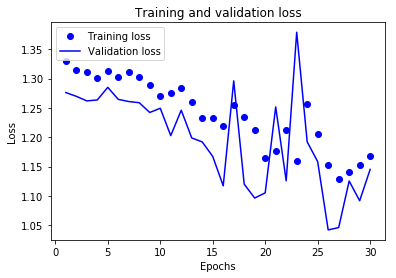

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()